In [1]:
import numpy as np

# Import local plotting functions and in-notebook display functions
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import Image


## What to do with a real-world ODE

+ Try the built-in solvers in your preferred language
+ RK4 or Dormand-Prince 8(3) with ultrafine timescale: sanity check / fiducial trajectory
+ Multiple timescales? Variable step
+ Vectorize the right hand side
+ Compute the Jacobian analytically and pass it to the solver
+ Use hardware acceleration
+ If working with integro-differential equation (especially non-local), delay equations, stochastic, etc--write your own solver

# An example problem: integrating a set of coupled oscillators

+ $N$ oscillators with frequency $\omega_i$ and mutual coupling strength $K$
+ $\theta_i(t)$ is the phase of oscillator $i$ at time $t$
+ At small $K$, the oscillators rotate freely. At large $K$, they synchronize
+ The equations of motion are

$$
\dot{\theta}_i = \omega_i + K \sum_{j=1}^N \sin(\theta_j - \theta_i)
$$


+ Used to describe the dynamics of neurons in the brain, fireflies at dusk, planetary orbits, etc

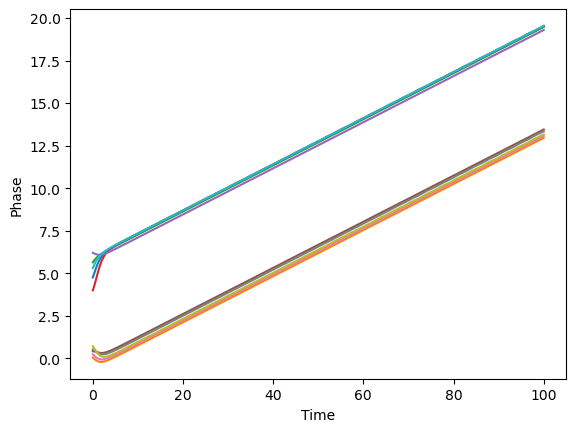

In [69]:
class KuramotoModel:
    """A set of coupled oscillators"""

    def __init__(self, N, K, w, random_state=None):
        self.N = N
        self.K = K
        self.random_state = random_state
        np.random.seed(random_state)
        self.w = np.random.normal(w, 0.1, N)

    def rhs(self, t, X):
        """Right-hand side of the Kuramoto model."""
        return self.w + self.K / self.N * np.sum(np.sin(X[:, None] - X), axis=0)


eq = KuramotoModel(N=10, K=1, w=0.1)

from scipy.integrate import solve_ivp
ic = np.random.uniform(0, 2*np.pi, eq.N) # initial oscillator phases

sol = solve_ivp(eq.rhs, (0, 100), ic, method='RK45', t_eval=np.linspace(0, 100, 1000))

plt.plot(sol.t, sol.y.T)
plt.xlabel('Time')
plt.ylabel('Phase')
plt.show()

# Speeding up numerical integration

### Why Python is bad (your advisor wants you to use Fortran)
+ Python Interpreter: translates Python code into bytecode (machine readable) at runtime
+ Python is not a compiled language

### What the Python interpreter does at runtime
+ Dynamic typing: type of variable is determined
+ Garbage collection: remove variables based on reference counting
+ Global interpreter lock: only one thread can run at a time, to avoid incorrect garbage collection due to different threads accessing the same variable


### A workaround: Just-in-time compilation: 
+ Compiles when the code is executed, then caches the compiled code for future calls
+ Identifies types, compiles to machine code local to the machine

### The L1 and L2 Cache

+ Memory hierarchy
+ + Registers (64 bit)
+ + L1 Cache (32 KB)
+ + L2 Cache (256 KB/core)
+ + L3 Cache (8 MB)
+ + Main Memory (32 GB)
+ + Disk (1 TB)
+ + Network (1 PB)
+ + Internet (1 EB)

+ Capacity versus latency

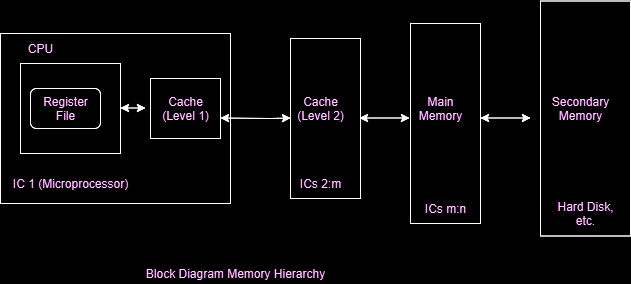

In [66]:
Image(filename='../resources/computer_memory.png', width=800)
# https://www.geeksforgeeks.org/levels-of-memory-in-operating-system/

Text(0, 0.5, 'Time (s)')

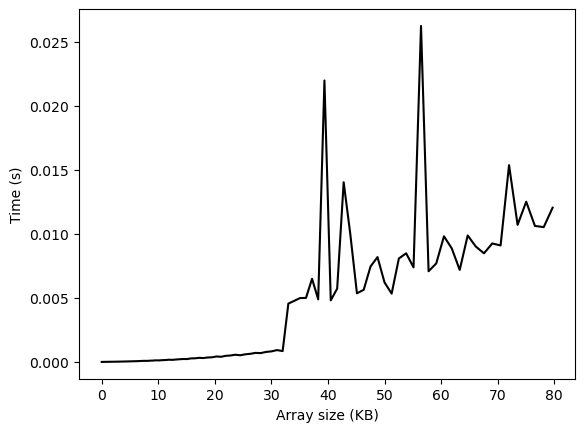

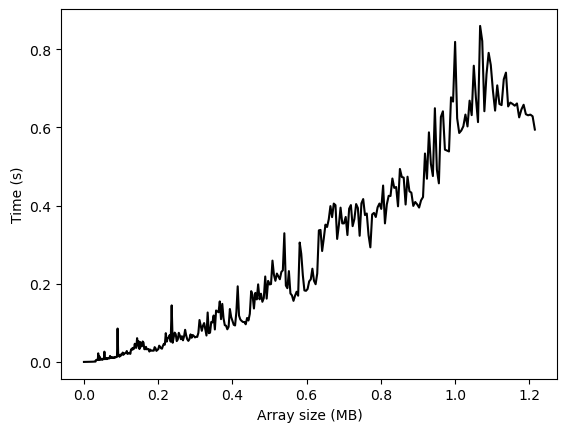

In [68]:
import timeit 
# nvals = (2 + np.logspace(0, 4, 50)).astype(int)
nvals = np.arange(2, 400)
np.random.seed(0)
a0 = np.random.random((nvals[-1], nvals[-1]))
all_times = list()
all_sizes = list()
for n in nvals:
    a = a0[:n, :n]
    t = timeit.timeit("a @ a", globals=globals(), number=n)
    all_reps = list()
    for i in range(10):
        all_reps.append(timeit.timeit("a @ a", globals=globals(), number=n))
    all_times.append(np.mean(all_reps))
    all_sizes.append(a.nbytes) # in MB
all_sizes = np.array(all_sizes)
all_times = np.array(all_times)


plt.figure()
plt.plot(all_sizes[:100] / 1024, all_times[:100], 'k')
plt.xlabel('Array size (KB)')
plt.ylabel('Time (s)')

plt.figure()
plt.plot(all_sizes / 1024**2, all_times, 'k')
plt.xlabel('Array size (MB)')
plt.ylabel('Time (s)')



Text(0.5, 0, 'Array Size (MB)')

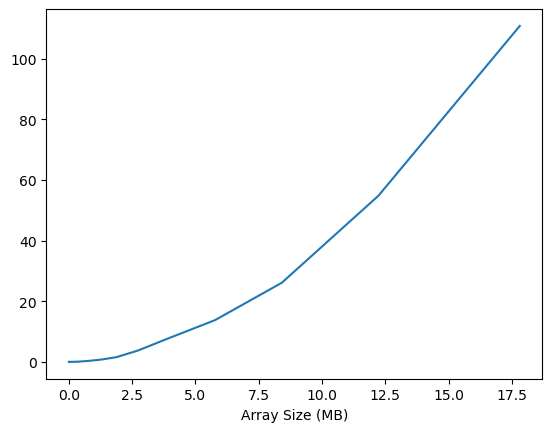

In [59]:
## results from a much longer timing run
plt.plot(all_sizes / 1024**2, all_times)
plt.xlabel('Array Size (MB)')

## Numba


Upsides:
+ Can be used to accelerate any Python code
+ Can match C performance on subroutines
+ Great for arrays
+ Can be deployed selectively on key subsets of code that need speed

Downsides:
+ Difficult to install (flashbacks to cMake)
+ Limited to a subset of Python operations

#### How it works

+ Python bytecode -> LLVM IR -> machine code

+ First call: 
    1. Infer argument types and identify common structures like list comprehensions, dot products, etc
    2. Generate a "compile-ready" form in language-independent syntax (intermediate representations)
    3. Compile the code to machine code (LLVM: IR --> Machine code)
    4. Cache the compiled code for future use

+ Subsequent calls: run compiled code directly

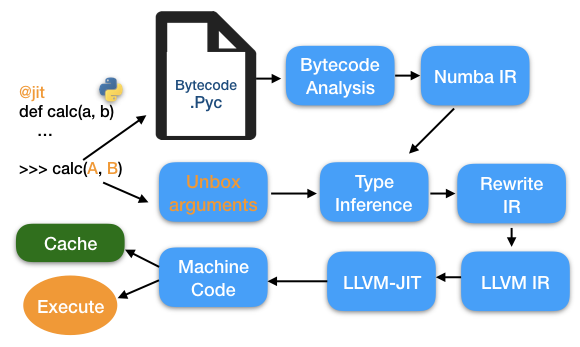

In [4]:
Image("../resources/numba_diagram.png")
# https://towardsdatascience.com/why-numba-sometime-way-slower-than-numpy-15d077390287

## Cython

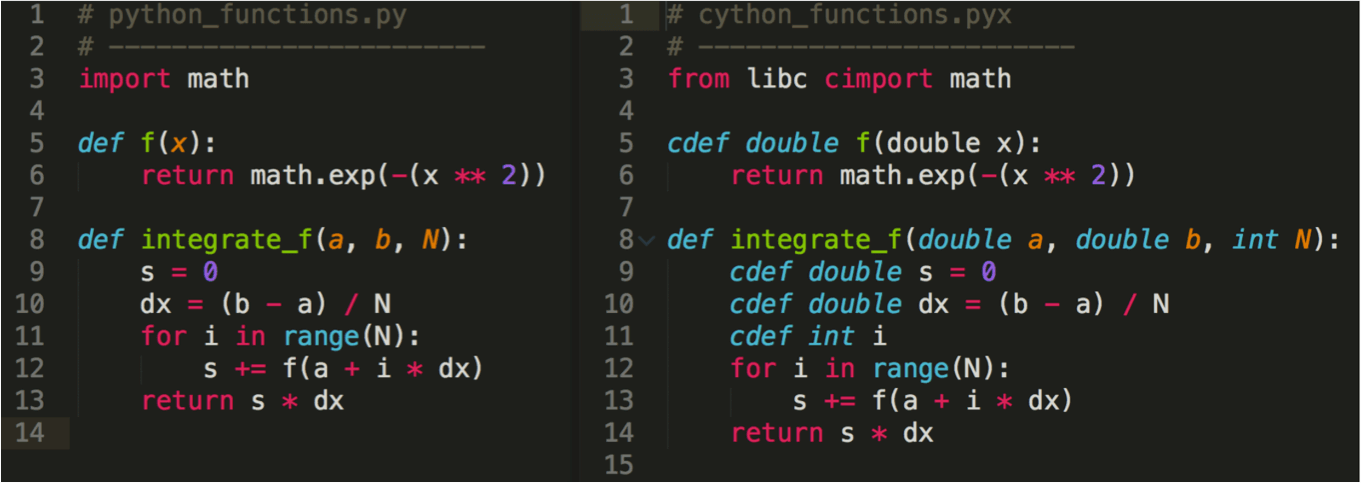

In [9]:
Image("../resources/cython_code.png", width=900)
# https://www.cardinalpeak.com/blog/faster-python-with-cython-and-pypy-part-1



+ Compiles Python code to C
+ A "super-set" of Python that allows you to write C-like code, call C functions, and use C data types
+ Will fall back to Python if you use unsupported features or have mixed types


### Downsides

+ Some install complications
+ Loses the readability and extensibility of pure Python
+ Not as easy to use as Numba
+ Many external libraries are not compatible with Cython
+ Appears to be declining in popularity among the scientific Python community (see [this](https://stackoverflow.com/questions/11227809/why-is-cython-better-than-c) StackOverflow post)



### My biased opinion: Try Numba or JAX, otherwise just use C or Julia

## JAX

+ Newest technology here
+ Converts Python code to XLA (Accelerated Linear Algebra)
+ XLA is a domain-specific language for linear algebra. Newer approach than LLVM
+ Backed by Google
+ First-class support for automatic differentiation

### My biased opinion: This is probably the future

### Automatic differentiation

+ Optimizaton: computing gradients and Hessians by hand is tricky and error-prone
+ Finite-differences are inexact and scale as O(d^2), where $d$ is the dimensionality of the ODE or optimization setting
+ Automatic differentiation is exact and scales as O(d)

In [ ]:
def double_well(x):
    """Double well potential function"""
    return x**4 - 2*x**2

def double_well_grad(x):
    """Derivative of double well potential function"""
    return 4*x**3 - 4*x

def double_well_hess(x):
    """Hessian of double well potential function"""
    return 12*x**2 - 4



In [ ]:
def double_well_primitive(x):
    """Decompose the double well calculation into primitive operations"""
    h1a = x**4
    h1b = 2*x**2
    h2 = h1a - h1b
    return h2

def double_well_primitive_grad(x):
    """Decompose the double well gradient calculation into primitive operations"""
    dh2dh1a = 1
    dh2dh1b = -1
    dh1adx = 4*x**3
    dh1bdx = 4*x
    dh2dx = dh2dh1a * dh1adx + dh2dh1b * dh1bdx
    return dh2dx

# Julia


+ A new language that is designed to be fast
+ Compiles to LLVM
+ Has a lot of the same features as Python, fixes some of the weird syntax, like 0-indexing
+ First class support for parallelism, distributed computing, GPU acceleration, and automatic differentiation

### Downsides

+ Not widely used outside of scientific computing community
+ Not yet as many libraries or devs as Python
+ Documentation improving, but still not as good as core Python libaries

### My biased opinion: ???